In [1]:
!pip install fuzzywuzzy
!pip install surprise
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357261 sha256=fb451a9420650e6420b441d23ddbff779fbc2bf9abb88ff9d20999e752eb7859
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from fuzzywuzzy import fuzz
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from google.colab import files
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
from surprise import SVD, SVDpp, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, BaselineOnly, CoClustering, NormalPredictor
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate

In [36]:
uploaded_files = files.upload()

Saving movies.csv to movies (1).csv


In [37]:
movies_df = pd.read_csv("movies.csv")
ratings_df = pd.read_csv("ratings.csv")

In [38]:
print(ratings_df.head())
print(movies_df.head(10))

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                        

In [39]:
# Exploratory Data Analysis (EDA)
print("Movies DataFrame Info:")
print(movies_df.info())
print("\nRatings DataFrame Info:")
print(ratings_df.info())

## Descriptive Statistics
print("Movies DataFrame Description:")
print(movies_df.describe())
print("\nRatings DataFrame Description:")
print(ratings_df.describe())

Movies DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

Ratings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
Movies DataFrame Description:
             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.00

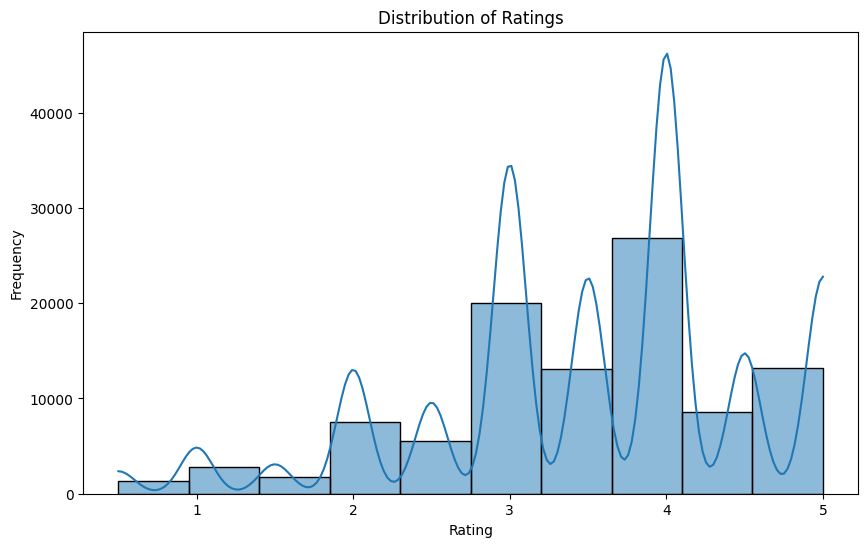

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

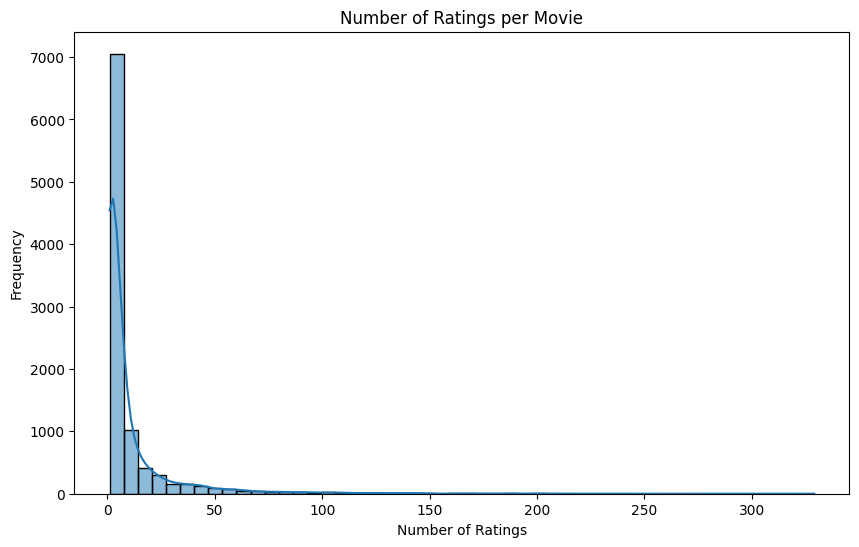

In [41]:
ratings_per_movie = ratings_df.groupby('movieId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

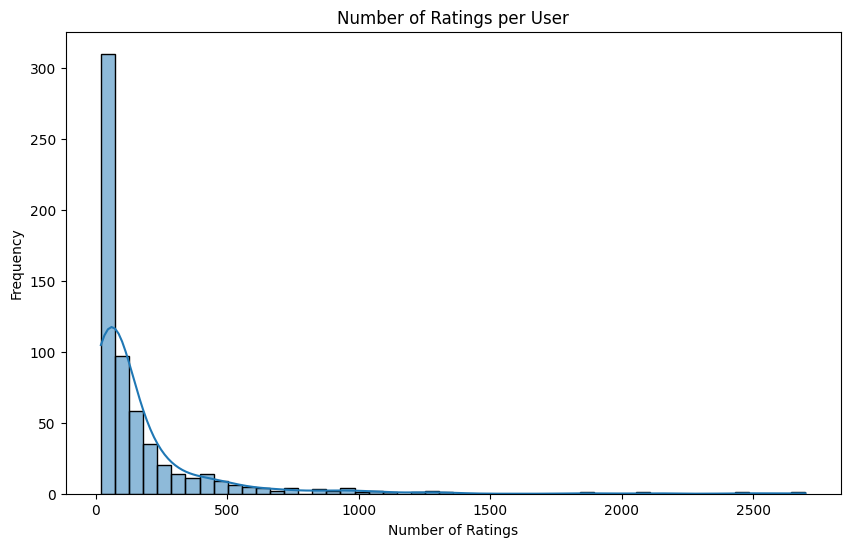

In [42]:
ratings_per_user = ratings_df.groupby('userId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

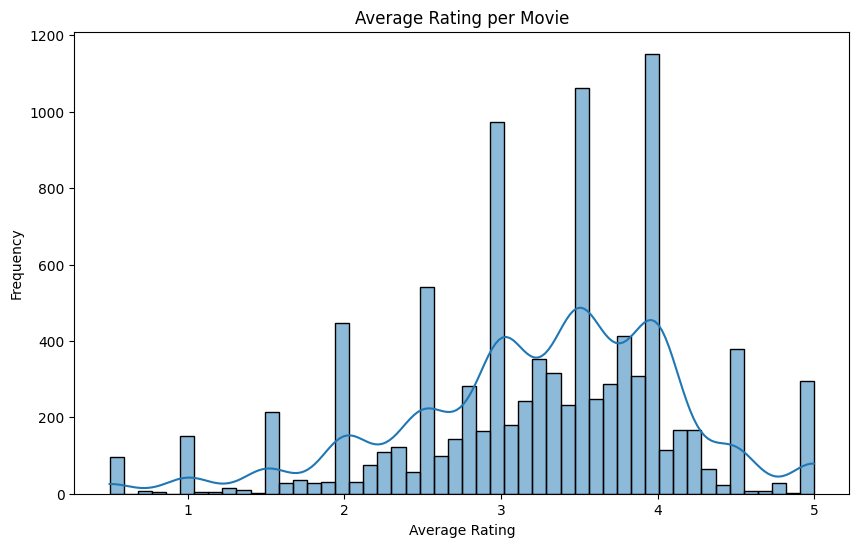

In [43]:
avg_rating_per_movie = ratings_df.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(avg_rating_per_movie, bins=50, kde=True)
plt.title('Average Rating per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

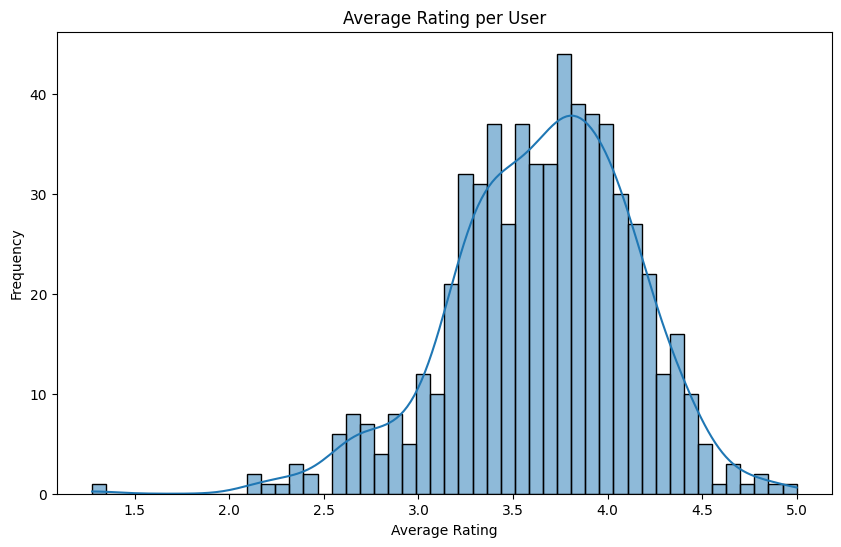

In [44]:
avg_rating_per_user = ratings_df.groupby('userId')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(avg_rating_per_user, bins=50, kde=True)
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

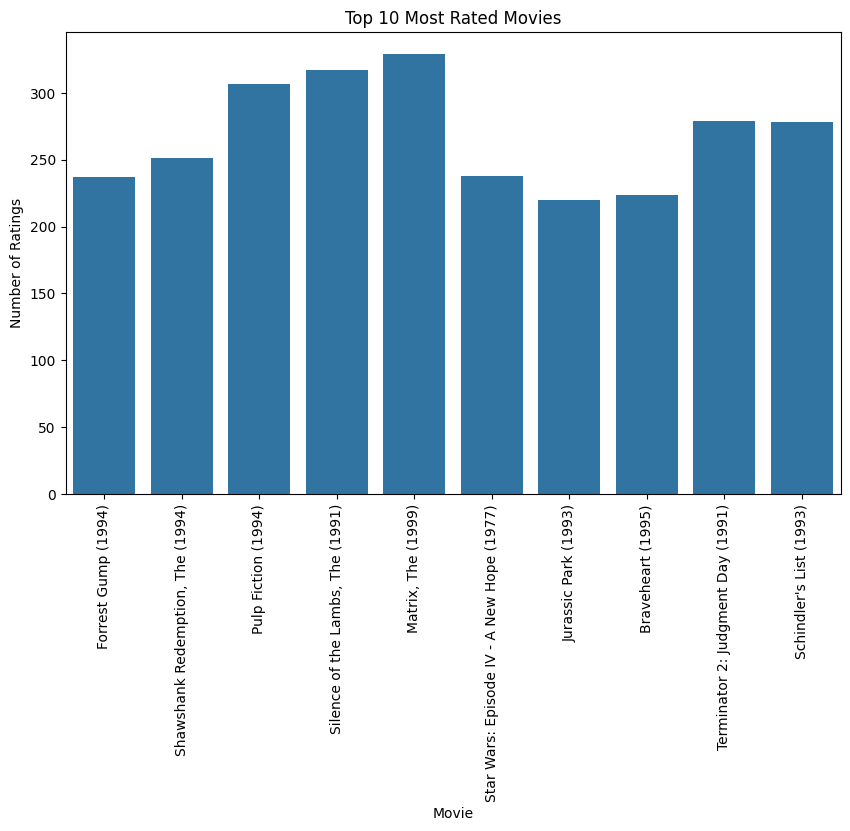

In [45]:
most_rated_movies = ratings_per_movie.sort_values(ascending=False).head(10)
most_rated_movies_titles = movies_df[movies_df['movieId'].isin(most_rated_movies.index)]
most_rated_movies = most_rated_movies.reset_index().merge(most_rated_movies_titles[['movieId', 'title']], on='movieId')

plt.figure(figsize=(10, 6))
sns.barplot(x='movieId', y=0, data=most_rated_movies)
plt.xticks(ticks=range(10), labels=most_rated_movies['title'], rotation=90)
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie')
plt.ylabel('Number of Ratings')
plt.show()

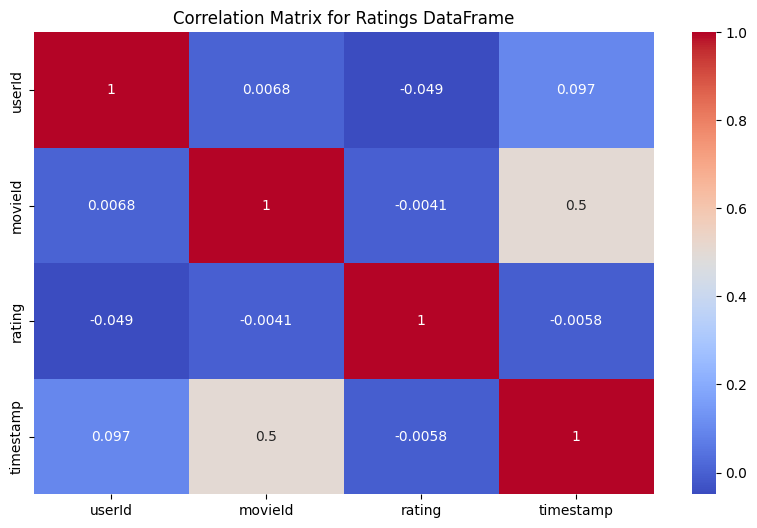

In [46]:
correlation_matrix = ratings_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Ratings DataFrame')
plt.show()

In [47]:
unique_ratings = ratings_df['rating'].unique()
max_rating = np.amax(unique_ratings)
min_rating = np.amin(unique_ratings)
print(unique_ratings)

[4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


In [48]:
title_to_movie_id = pd.Series(movies_df.movieId.values, index=movies_df.title).to_dict()
movie_id_to_title = {v: k for k, v in title_to_movie_id.items()}
movie_id_to_index = pd.Series(movies_df.index.values, index=movies_df.movieId).to_dict()
all_movie_ids = movies_df['movieId'].unique()

In [49]:
def get_movie_id(movie_title):
    if movie_title in title_to_movie_id:
        return title_to_movie_id[movie_title]
    else:
        similar_titles = [(title, movie_id, fuzz.ratio(title.lower(), movie_title.lower()))
                          for title, movie_id in title_to_movie_id.items()
                          if fuzz.ratio(title.lower(), movie_title.lower()) >= 60]
        if not similar_titles:
            print("Oh! This movie does not exist in the database.")
            return None
        similar_titles.sort(key=lambda x: x[2], reverse=True)
        print(f"The matched item might be: {similar_titles[0][0]}, ratio={similar_titles[0][2]}")
        return similar_titles[0][1]

In [50]:
def genre_tokenizer(text):
    tokens = [PorterStemmer().stem(word).lower() for word in text.split('|')
              if word.lower() not in stopwords.words('english')]
    return tokens

In [51]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=genre_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['genres'])
cosine_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [52]:
print(tfidf_matrix.shape)
print(cosine_similarity_matrix.shape)
print(movies_df.shape)

(9742, 20)
(9742, 9742)
(9742, 3)


In [53]:
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [54]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
grid_search.fit(data)

In [55]:
best_svd_params = grid_search.best_params['rmse']
best_svd_model = grid_search.best_estimator['rmse']
best_svd_model.fit(data.build_full_trainset())

In [56]:
def get_closest_rating(prediction, ratings_array):
    return ratings_array[np.argmin([np.abs(item - prediction) for item in ratings_array])]

predicted_rating = best_svd_model.predict(1, 1)
print("Actual rating:", ratings_df[(ratings_df.userId == 1) & (ratings_df.movieId == 1)]['rating'])
print("Predicted rating:", predicted_rating.est)

Actual rating: 0    4.0
Name: rating, dtype: float64
Predicted rating: 4.380805969522099


In [57]:
def recommend_items_based_on_content(similarity_matrix, all_movie_ids, ratings_data, id_to_title_map,
                                     id_to_index_map, favorite_movies, num_recommendations, user_id=-99):
    if user_id == -99:
        user_id = np.amax(ratings_data['userId'].unique()) + 1
    elif user_id == -1:
        user_id = np.amax(ratings_data['userId'].unique())

    favorite_movie_ids = [get_movie_id(movie) for movie in favorite_movies]
    existing_movie_ids = list(ratings_data[ratings_data.userId == user_id]['movieId'].unique()) + favorite_movie_ids
    movie_ids_to_recommend = [movie_id for movie_id in all_movie_ids if movie_id not in existing_movie_ids]

    index = id_to_index_map[favorite_movie_ids[0]]
    similarity_scores = list(enumerate(similarity_matrix[index]))
    similarity_scores.sort(key=lambda x: x[1], reverse=True)

    top_movie_indices = [score[0] for score in similarity_scores
                         if score[0] in [id_to_index_map[movie_id] for movie_id in movie_ids_to_recommend]][:num_recommendations]

    return [movies_df.loc[idx].title for idx in top_movie_indices]

In [58]:
def recommend_items_based_on_user_preference(svd_params, all_movie_ids, ratings_data, id_to_title_map,
                                             favorite_movies, num_recommendations, user_id=-99):
    favorite_movie_ids = [get_movie_id(movie) for movie in favorite_movies]

    if user_id == -99:
        user_id = np.amax(ratings_data['userId'].unique()) + 1
    elif user_id == -1:
        user_id = np.amax(ratings_data['userId'].unique())

    user_rows = [[user_id, movie_id, max_rating] for movie_id in favorite_movie_ids]
    combined_data = pd.concat([ratings_data, pd.DataFrame(user_rows, columns=['userId', 'movieId', 'rating'])],
                              ignore_index=True, sort=False)

    movie_ids_to_recommend = [movie_id for movie_id in all_movie_ids
                              if movie_id not in combined_data[combined_data.userId == user_id]['movieId'].unique()]

    reader = Reader(rating_scale=(min_rating, max_rating))
    data = Dataset.load_from_df(combined_data, reader)
    model = SVD(**svd_params)
    model.fit(data.build_full_trainset())

    predictions = [model.predict(user_id, movie_id) for movie_id in movie_ids_to_recommend]
    predictions.sort(key=lambda x: x.est, reverse=True)

    top_movie_ids = [pred.iid for pred in predictions[:num_recommendations]]
    return [id_to_title_map[movie_id] for movie_id in top_movie_ids]

In [59]:
def recommend_hybrid(content_recommendations, user_preference_recommendations):
    hybrid_recommendations = list(set(content_recommendations + user_preference_recommendations))
    return hybrid_recommendations[:num_recommendations]

In [60]:
favorite_movies = input('Enter your Favourate movies as comma seperated values')
num_recommendations = int(input('Enter number of required reccomentations'))

favorite_movies_list = favorite_movies.split(',')

# favorite_movies_list = ['Shawshank Redemption']
# num_recommendations = 10

Enter your Favourate movies as comma seperated valuesShawshank Redemption,Toy Story2
Enter number of required reccomentations8


In [61]:
# Generate item-based recommendations
item_based_recommendations = recommend_items_based_on_content(
    similarity_matrix=cosine_similarity_matrix,
    all_movie_ids=all_movie_ids,
    ratings_data=ratings_df[['userId', 'movieId', 'rating']],
    id_to_title_map=movie_id_to_title,
    id_to_index_map=movie_id_to_index,
    favorite_movies=favorite_movies_list,
    num_recommendations=num_recommendations
)

The matched item might be: Shawshank Redemption, The (1994), ratio=77
The matched item might be: Toy Story 2 (1999), ratio=71


In [62]:
# Generate user-based recommendations
user_based_recommendations = recommend_items_based_on_user_preference(
    svd_params=best_svd_params,
    all_movie_ids=all_movie_ids,
    ratings_data=ratings_df[['userId', 'movieId', 'rating']],
    id_to_title_map=movie_id_to_title,
    favorite_movies=favorite_movies_list,
    num_recommendations=num_recommendations
)

The matched item might be: Shawshank Redemption, The (1994), ratio=77
The matched item might be: Toy Story 2 (1999), ratio=71


In [63]:
# print('Input 1 for item based on content ,2 for user preference based and 3 for Hybrid reccomendation')
# inp = int(input())

In [66]:
# Displaying recommendations
print(f'The movies similar to {favorite_movies_list} are:')
for i, title in enumerate(item_based_recommendations):
    print(f"{i + 1}. {title}")
print('\n\n')
print(f'The users who like {favorite_movies_list} also like:')
for i, title in enumerate(user_based_recommendations):
    print(f"{i + 1}. {title}")

The movies similar to ['Shawshank Redemption', 'Toy Story2'] are:
1. Casino (1995)
2. Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
3. Dead Man Walking (1995)
4. Hate (Haine, La) (1995)
5. Young Poisoner's Handbook, The (1995)
6. Heavenly Creatures (1994)
7. New Jersey Drive (1995)
8. Once Were Warriors (1994)



The users who like ['Shawshank Redemption', 'Toy Story2'] also like:
1. Godfather, The (1972)
2. Lawrence of Arabia (1962)
3. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
4. Fight Club (1999)
5. Rear Window (1954)
6. Boondock Saints, The (2000)
7. Pulp Fiction (1994)
8. Goodfellas (1990)


In [67]:
hybrid_recommendations = recommend_hybrid(item_based_recommendations, user_based_recommendations)

In [68]:
print("\nHybrid Recommendations:")
for i, movie in enumerate(hybrid_recommendations):
    print(f"{i + 1}. {movie}")


Hybrid Recommendations:
1. Heavenly Creatures (1994)
2. Once Were Warriors (1994)
3. Godfather, The (1972)
4. Hate (Haine, La) (1995)
5. Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
6. Boondock Saints, The (2000)
7. Goodfellas (1990)
8. Dead Man Walking (1995)


In [33]:
# @title Using better Hybrid techniques

Using hybrid techniques :-
Weighted sum of scores, Averaging the scores, Stacking, Blending, Switching, Cascade

In [69]:
movie_id_to_title = pd.Series(movies_df.title.values, index=movies_df.movieId).to_dict()
title_to_movie_id = {v: k for k, v in movie_id_to_title.items()}
movie_id_to_index = pd.Series(movies_df.index.values, index=movies_df.movieId).to_dict()

def tokenize(text):
    tokens = [PorterStemmer().stem(word).lower() for word in text.split('|') if word not in stopwords.words('english')]
    return tokens

tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['genres'])
cosine_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Collaborative Filtering using scikit-learn
# Convert the ratings dataframe into a user-item matrix
user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [104]:
# svd = TruncatedSVD(n_components=20, random_state=42)
# reduced_user_item_matrix = svd.fit_transform(user_item_matrix)

# knn = NearestNeighbors(metric='cosine', algorithm='brute')
# knn.fit(reduced_user_item_matrix)

In [106]:
# Applying TruncatedSVD for dimensionality reduction on the user-item matrix
svd = TruncatedSVD(n_components=20, random_state=42)
reduced_user_item_matrix = svd.fit_transform(user_item_matrix)

# Fit the KNN model with the reduced user-item matrix
knn_model = NearestNeighbors(n_neighbors=num_recommendations, algorithm='auto').fit(reduced_user_item_matrix)


In [107]:
# Function to get movie ID using fuzzywuzzy
def get_movie_id(movie_name):
    if movie_name in title_to_movie_id:
        return title_to_movie_id[movie_name]
    else:
        similar_movies = [(title, movie_id, fuzz.ratio(title.lower(), movie_name.lower()))
                          for title, movie_id in title_to_movie_id.items() if fuzz.ratio(title.lower(), movie_name.lower()) >= 60]
        if similar_movies:
            similar_movies.sort(key=lambda x: x[2], reverse=True)
            return similar_movies[0][1]
        else:
            return None

In [108]:
# Function to recommend items based on content similarity with scores
def recommend_items_based_on_content_with_scores(similarity_matrix, all_movie_ids, ratings_data, id_to_title_map, id_to_index_map, favorite_movies, num_recommendations):
    favorite_movie_ids = [get_movie_id(movie) for movie in favorite_movies]
    movie_id_user_exists = list(ratings_data['movieId'].unique())
    movie_id_user_exists += favorite_movie_ids
    movie_id_candidates = [movie_id for movie_id in all_movie_ids if movie_id not in movie_id_user_exists]

    index = id_to_index_map[favorite_movie_ids[0]]
    similarity_scores = list(enumerate(similarity_matrix[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    top_movie_indices = [idx for idx, score in similarity_scores if idx in [id_to_index_map[movie_id] for movie_id in movie_id_candidates]]
    top_movie_titles = [(id_to_title_map[all_movie_ids[idx]], score) for idx, score in similarity_scores[:num_recommendations]]

    return top_movie_titles

# Function to recommend items based on user preference with scores using collaborative filtering
def recommend_items_based_on_user_preference_with_scores(knn_model, reduced_matrix, user_item_matrix, all_movie_ids, id_to_title_map, favorite_movies, num_recommendations):
    favorite_movie_ids = [get_movie_id(movie) for movie in favorite_movies]
    user_profile = reduced_matrix.mean(axis=0).reshape(1, -1)
    distances, indices = knn_model.kneighbors(user_profile, n_neighbors=num_recommendations)

    recommended_movie_ids = [all_movie_ids[idx] for idx in indices.flatten()]
    recommended_movie_titles = [(id_to_title_map[movie_id], 1 - distances.flatten()[i]) for i, movie_id in enumerate(recommended_movie_ids)]

    return recommended_movie_titles

In [92]:
# # Function to recommend items based on content similarity with scores
# def recommend_items_based_on_content_with_scores(similarity_matrix, all_movie_ids, ratings_data, id_to_title_map, id_to_index_map, favorite_movies, num_recommendations):
#     favorite_movie_ids = [get_movie_id(movie) for movie in favorite_movies]
#     movie_id_user_exists = list(ratings_data['movieId'].unique())
#     movie_id_user_exists += favorite_movie_ids
#     movie_id_candidates = [movie_id for movie_id in all_movie_ids if movie_id not in movie_id_user_exists]

#     index = id_to_index_map[favorite_movie_ids[0]]
#     similarity_scores = list(enumerate(similarity_matrix[index]))
#     similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

#     top_movie_indices = [idx for idx, score in similarity_scores if idx in [id_to_index_map[movie_id] for movie_id in movie_id_candidates]]
#     top_movie_titles = [(id_to_title_map[all_movie_ids[idx]], score) for idx, score in similarity_scores[:num_recommendations]]

#     return top_movie_titles

# # Function to recommend items based on user preference with scores using collaborative filtering
# def recommend_items_based_on_user_preference_with_scores(knn_model, reduced_matrix, user_item_matrix, all_movie_ids, id_to_title_map, favorite_movies, num_recommendations):
#     favorite_movie_ids = [get_movie_id(movie) for movie in favorite_movies]
#     user_profile = user_item_matrix.mean(axis=0).values.reshape(1, -1)
#     distances, indices = knn_model.kneighbors(user_profile, n_neighbors=num_recommendations)

#     recommended_movie_ids = [all_movie_ids[idx] for idx in indices.flatten()]
#     recommended_movie_titles = [(id_to_title_map[movie_id], 1 - distances.flatten()[i]) for i, movie_id in enumerate(recommended_movie_ids)]

#     return recommended_movie_titles

In [109]:
# Averaging the scores
def recommend_hybrid_average(content_recommendations, user_recommendations, num_recommendations):
    combined_scores = {}
    for movie, score in content_recommendations:
        combined_scores[movie] = combined_scores.get(movie, 0) + score
    for movie, score in user_recommendations:
        combined_scores[movie] = combined_scores.get(movie, 0) + score
    sorted_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    return [movie for movie, score in sorted_recommendations][:num_recommendations]

In [ ]:
# Weighted sum of scores
def recommend_hybrid_weighted(content_recommendations, user_recommendations, num_recommendations, content_weight=0.5, user_weight=0.5):
    combined_scores = {}
    for movie, score in content_recommendations:
        combined_scores[movie] = combined_scores.get(movie, 0) + score * content_weight
    for movie, score in user_recommendations:
        combined_scores[movie] = combined_scores.get(movie, 0) + score * user_weight
    sorted_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    return [movie for movie, score in sorted_recommendations][:num_recommendations]


In [125]:
# Stacking
def recommend_hybrid_stacking(content_recommendations, user_recommendations, num_recommendations):
    data = []
    target = []
    for movie, score in content_recommendations:
        data.append([score, 0])
        target.append(score)
    for movie, score in user_recommendations:
        data.append([0, score])
        target.append(score)

    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    combined_scores = {}
    for i, (movie, score) in enumerate(content_recommendations):
        combined_scores[movie] = combined_scores.get(movie, 0) + predictions[i]
    for i, (movie, score) in enumerate(user_recommendations):
        combined_scores[movie] = combined_scores.get(movie, 0) + predictions[i + len(content_recommendations)]

    sorted_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    return [movie for movie, score in sorted_recommendations][:num_recommendations]


# # Stacking
# def recommend_hybrid_stacking(content_recommendations, user_recommendations, num_recommendations):
#     data = []
#     target = []
#     for movie, score in content_recommendations:
#         data.append([score, 0])
#         target.append(1)
#     for movie, score in user_recommendations:
#         data.append([0, score])
#         target.append(1)

#     X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)

#     combined_scores = {}
#     for i, (movie, score) in enumerate(content_recommendations):
#         combined_scores[movie] = combined_scores.get(movie, 0) + predictions[i]
#     for i, (movie, score) in enumerate(user_recommendations):
#         combined_scores[movie] = combined_scores.get(movie, 0) + predictions[i + len(content_recommendations)]

#     sorted_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
#     return [movie for movie, score in sorted_recommendations][:num_recommendations]


In [127]:
# Blending
def recommend_hybrid_blending(content_recommendations, user_recommendations, num_recommendations):
    data = []
    target = []
    for movie, score in content_recommendations:
        data.append([score, 0])
        target.append(score)
    for movie, score in user_recommendations:
        data.append([0, score])
        target.append(score)

    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    combined_scores = {}
    for i, (movie, score) in enumerate(content_recommendations):
        combined_scores[movie] = combined_scores.get(movie, 0) + predictions[i]
    for i, (movie, score) in enumerate(user_recommendations):
        combined_scores[movie] = combined_scores.get(movie, 0) + predictions[i + len(content_recommendations)]

    sorted_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    return [movie for movie, score in sorted_recommendations][:num_recommendations]


# # Blending
# def recommend_hybrid_blending(content_recommendations, user_recommendations, num_recommendations):
#     data = []
#     target = []
#     for movie, score in content_recommendations:
#         data.append([score, 0])
#         target.append(1)
#     for movie, score in user_recommendations:
#         data.append([0, score])
#         target.append(1)

#     X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
#     model = RandomForestRegressor(n_estimators=100, random_state=42)
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)

#     combined_scores = {}
#     for i, (movie, score) in enumerate(content_recommendations):
#         combined_scores[movie] = combined_scores.get(movie, 0) + predictions[i]
#     for i, (movie, score) in enumerate(user_recommendations):
#         combined_scores[movie] = combined_scores.get(movie, 0) + predictions[i + len(content_recommendations)]

#     sorted_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
#     return [movie for movie, score in sorted_recommendations][:num_recommendations]


In [ ]:
# Switching
def recommend_hybrid_switching(content_recommendations, user_recommendations, num_recommendations, threshold=0.7):
    combined_recommendations = []
    for movie, score in content_recommendations:
        if score >= threshold:
            combined_recommendations.append(movie)
    for movie, score in user_recommendations:
        if score >= threshold:
            combined_recommendations.append(movie)
    return combined_recommendations[:num_recommendations]

In [ ]:
# Cascade
def recommend_hybrid_cascade(content_recommendations, user_recommendations, num_recommendations):
    combined_recommendations = []
    for movie, score in content_recommendations:
        combined_recommendations.append(movie)
        if len(combined_recommendations) >= num_recommendations:
            break
    for movie, score in user_recommendations:
        if movie not in combined_recommendations:
            combined_recommendations.append(movie)
        if len(combined_recommendations) >= num_recommendations:
            break
    return combined_recommendations[:num_recommendations]

In [110]:
favorite_movies = ['Toy Story (1995)']
num_recommendations = 10

In [112]:
# Content-based recommendations with scores
content_recommendations_with_scores = recommend_items_based_on_content_with_scores(
    similarity_matrix=cosine_similarity_matrix,
    all_movie_ids=movies_df['movieId'].values,
    ratings_data=ratings_df,
    id_to_title_map=movie_id_to_title,
    id_to_index_map=movie_id_to_index,
    favorite_movies=favorite_movies,
    num_recommendations=num_recommendations
)

In [113]:
content_recommendations_with_scores

[('Toy Story (1995)', 1.0000000000000004),
 ('Antz (1998)', 1.0000000000000004),
 ('Toy Story 2 (1999)', 1.0000000000000004),
 ('Adventures of Rocky and Bullwinkle, The (2000)', 1.0000000000000004),
 ("Emperor's New Groove, The (2000)", 1.0000000000000004),
 ('Monsters, Inc. (2001)', 1.0000000000000004),
 ('Wild, The (2006)', 1.0000000000000004),
 ('Shrek the Third (2007)', 1.0000000000000004),
 ('Tale of Despereaux, The (2008)', 1.0000000000000004),
 ('Asterix and the Vikings (Astérix et les Vikings) (2006)',
  1.0000000000000004)]

In [ ]:
# Collaborative filtering recommendations with scores
user_recommendations_with_scores = recommend_items_based_on_user_preference_with_scores(
    knn_model=knn_model,
    reduced_matrix=reduced_user_item_matrix,
    user_item_matrix=user_item_matrix,
    all_movie_ids=movies_df['movieId'].values,
    id_to_title_map=movie_id_to_title,
    favorite_movies=favorite_movies,
    num_recommendations=num_recommendations
)

In [114]:
user_recommendations_with_scores

[('Paper, The (1994)', 0.9193425077566961),
 ('Red Rock West (1992)', 0.9062105974182371),
 ('True Crime (1996)', 0.8957600145368348),
 ('Lightning Jack (1994)', 0.89328236295916),
 ('Swimming with Sharks (1995)', 0.8885346948529436),
 ('From Dusk Till Dawn (1996)', 0.887671031868563),
 ('What Happened Was... (1994)', 0.8862890533483705),
 ('8 Seconds (1994)', 0.8731401560414422),
 ('Jerky Boys, The (1995)', 0.8727303914506737),
 ('Barbarella (1968)', 0.871334384921647)]

In [115]:
# Averaging the scores
average_recommendations = recommend_hybrid_average(
    content_recommendations=content_recommendations_with_scores,
    user_recommendations=user_recommendations_with_scores,
    num_recommendations=num_recommendations
)

In [117]:
average_recommendations

['Toy Story (1995)',
 'Antz (1998)',
 'Toy Story 2 (1999)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 "Emperor's New Groove, The (2000)",
 'Monsters, Inc. (2001)',
 'Wild, The (2006)',
 'Shrek the Third (2007)',
 'Tale of Despereaux, The (2008)',
 'Asterix and the Vikings (Astérix et les Vikings) (2006)']

In [116]:
# Weighted sum of scores
weighted_recommendations = recommend_hybrid_weighted(
    content_recommendations=content_recommendations_with_scores,
    user_recommendations=user_recommendations_with_scores,
    num_recommendations=num_recommendations
)

In [118]:
weighted_recommendations

['Toy Story (1995)',
 'Antz (1998)',
 'Toy Story 2 (1999)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 "Emperor's New Groove, The (2000)",
 'Monsters, Inc. (2001)',
 'Wild, The (2006)',
 'Shrek the Third (2007)',
 'Tale of Despereaux, The (2008)',
 'Asterix and the Vikings (Astérix et les Vikings) (2006)']

In [130]:
# Stacking
stacking_recommendations = recommend_hybrid_stacking(
    content_recommendations=content_recommendations_with_scores,
    user_recommendations=user_recommendations_with_scores,
    num_recommendations=num_recommendations
)

In [129]:
# Blending
blending_recommendations = recommend_hybrid_blending(
    content_recommendations=content_recommendations_with_scores,
    user_recommendations=user_recommendations_with_scores,
    num_recommendations=num_recommendations
)

In [121]:
# Switching
switching_recommendations = recommend_hybrid_switching(
    content_recommendations=content_recommendations_with_scores,
    user_recommendations=user_recommendations_with_scores,
    num_recommendations=num_recommendations
)

In [123]:
switching_recommendations

['Toy Story (1995)',
 'Antz (1998)',
 'Toy Story 2 (1999)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 "Emperor's New Groove, The (2000)",
 'Monsters, Inc. (2001)',
 'Wild, The (2006)',
 'Shrek the Third (2007)',
 'Tale of Despereaux, The (2008)',
 'Asterix and the Vikings (Astérix et les Vikings) (2006)']

In [122]:
# Cascade
cascade_recommendations = recommend_hybrid_cascade(
    content_recommendations=content_recommendations_with_scores,
    user_recommendations=user_recommendations_with_scores,
    num_recommendations=num_recommendations
)

In [124]:
cascade_recommendations

['Toy Story (1995)',
 'Antz (1998)',
 'Toy Story 2 (1999)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 "Emperor's New Groove, The (2000)",
 'Monsters, Inc. (2001)',
 'Wild, The (2006)',
 'Shrek the Third (2007)',
 'Tale of Despereaux, The (2008)',
 'Asterix and the Vikings (Astérix et les Vikings) (2006)']